# A Model-Free Reinforcement Learning Trading Agent

## Introduction

The intent of this project is to demonstrate an already studied application of Q-Learning (the application as a trading agent) but add an important feature, that is the use of fundamental corporate data. 

The most intuitive input into a learning algorithm that intends to make stock buy and sell recommendations are price and volume related data (i.e. data that is directly derived from the assets stock price and trading volume). A whole discipline named technical analysis is devoted to deriving yet another metric based on price and volume information that is hoped to give valuable insight and trading signals. The efficacy of this approach is challanged and much discussed in academic literature yet there is a large community of people basing stock recommendations on technical analysis.
In this project we will use technical indicators as 

### Simplifications and Assumptions

This project does not make any claims of producing a real world trading agent, recognising that there are many considerations and real world complications to take into account which are out of the scope of this project.


* __No trading costs__: trading costs are an important aspect to consider in real life investing as such cost can make up a significant part of the maintenance cost of a portfolio for high turnover portfolios or illiquid assets. In this project we simplify and ignore trading costs.

* __Perfectly divisible shares__: this project uses a mean variance optimisation to find optimal holding weights which are computed in continuous space. In the real world a fraction might not easily be tradeable. This restriction is relaxed.

* __No control perspective__: the agent acting in this space takes the perspective of a minor market participant with no pricing influence or market movement capabilities. This assumptions is most closely related to the real world where a financial market is made up of a large number of individual participant, each individually only comprising marginal important to the overall market. This has implications for the Q-learner in as much as there are no actual state transitions modeled (as the agent can't influence the state of the environment).

* __No shorting__: the portfolio will never over invest itself or use shorting strategies. On the other hand the portfolio might be fully invested in cash if the agent decides that no stocks at all should be held. This is a convenient simplification so as to not force the learner to buy at least one asset but is is to be noted that this is a departure from real world requirements of fully invested portfolios (an active manager is not paid to hold cash).

## Imports

This project utilises the pandas and numpy modules for data manipulation as well as the portfolioopt module for mean variance portfolio optimisation.

In addition to these third party modules the below artefacts are utilised which were created as part of this project:

* __FlatFileDataService__ and __QuandlYahooDataService__: both provide a __get_data__ method which retrieves a panel whiere each dataframe represents a different underlying data item (e.g. Price or Net Income) and the dataframe itself is made up of a time series (y) for a list of assets (x) with values for given item. For this report the flat file data service can be used as all input data has been provided.
* __FinancialDataService__: sets on top of the above file or quandl-yahoo data service and computes derived items (i.e. data items that can be derived of other items which need to be pulled from file or web) and performs data enrichment operations (fill forwarding etc).
* __TradingAgent__: encapsulates the underlying learning system and steps through time to construct mean variance portfolio holding weights based on a list of BUY and SELL recommendations the learning algorithm provided.



In [6]:
import numpy as np
import pandas as pd
from data import QuandlYahooDataService
from data import FlatFileDataService
from data import FinancialDataService
import portfolioopt as pfopt
import datetime as datetime

import TradingAgent as TradingAgent

%matplotlib inline

In [7]:
path = '../data/'
fds = FinancialDataService(FlatFileDataService(path).get_data)

## Input Data

In addition to the traditional price derived metrics we are going to pull various fundamental data items which will be used to gain insight into an asset's profitability, financial health, etc.

As a reference univere of assets we will use the DOW Jones Industrial Average (DJIA) constituents. There are primarily two reasons for this choice:
1. the DJIA is made up of 30 assets which is a small enough number to not overly complicate this project and introduce excess computational complexity (e.g. by using the S&P500) yet is made up of enough assets to achieve portfolio diversification effects.
2. The DJIA is a well understood price-weighted index and performance data is readily available for comparison purposes.

The raw data pulled here will later be discretized and cast into a state-space for q-learning.

In [15]:
items = ['REVENUE', 'NET_INCOME', 'AVERAGE_ASSETS', 'AVERAGE_EQUITY', 'INTEREST_EXPENSE', 'EBIT', 'EBT', \
         'DIVIDEND_YIELD', 'NET_PROFIT_MARGIN', 'LEVERAGE', 'INTEREST_BURDEN', 'INTEREST_COVERAGE', 'PRICE']

tickers = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'KO', 'DD', 'XOM', \
           'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', \
           'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', \
           'VZ', 'WMT', 'DIS']

data = fds.get_data(items=items, tickers=tickers)

### Exploring the Data

Below code shows the head of the __LEVERAGE__ data item for the first 5 assets.

The example shows that data has been fill forwarded. Fundamental data originates from the company's financial statements and are slow moving (a listed company is required to publish audited financial statements once a year).

In [14]:
data.get("LEVERAGE").head()[tickers[0:5]]

,AAPL,AXP,BA,CAT,CSCO
Date,,,,,
2008-08-13,1.703583,12.325793,7.034865,6.345891,1.686684
2008-08-14,1.703583,12.325793,7.034865,6.345891,1.686684
2008-08-15,1.703583,12.325793,7.034865,6.345891,1.686684
2008-08-18,1.703583,12.325793,7.034865,6.345891,1.686684
2008-08-19,1.703583,12.325793,7.034865,6.345891,1.686684


## Trading Agent

The trading agent class encapsulates the underlying learning system. It sets on top of the data space obtained earlier and has the following responsibilities:

1. train the learner without actually acting and investint.
2. use the recommendations of the learner to form a holding portfolio which's weights are recorded in time to later produce performance figures.

For each of the two items above the agent needs to be able to do the below as it steps through time:

* take the raw input data at time *t* and compute the variables that form the state space
    * standardise variables (zscore)
    * discretise variables (bucketing)
* for each asset at time *t* obtain the recommended action from the Q-learner (either Buy or Sell)
* obtain holding weights for assets at time *t* by executing a mean variance optimisation
    * only consider those assets recommended as Buy
    * compute asset returns for given assets up to time *t* (using the __PRICE__ data item)
    * compute covariance matrix for asset returns
    * use covariance matrix to compute minimum variance portfolio
    * rebalance portfolio at time *t* with given optimal weights (not in learning mode)
* compute reward and update the Q-learner 
    * portfolios are rebalanced at a given frequency (see below). The reward is based on the sharpe ratio of the bought or sold asset over the chosen frequency. E.g. 

In [9]:
agent = TradingAgent(data)

TypeError: 'module' object is not callable

### Training the Agent

To prevent starting off a portfolio with completely uninformed trades and bets the system is pre-trained by stepping through a predefined number of periods and simulate a portfolio without actually recording the performance (i.e. holdings are computed and simualted as but the results of those holdings won't enter the final performance comparison).

In addition we specify a holding period which indicates in which intervals assets are re-assessed and and the portfolio is rebalanced. In this example we choose one week as a portfolio rabalance frequency.

In [4]:
learning_periods = 255
rebalance_frequency = 5

agent.learn(learning_periods, rebalance_frequency)

NameError: name 'agent' is not defined

In [35]:
agent.trade(5)

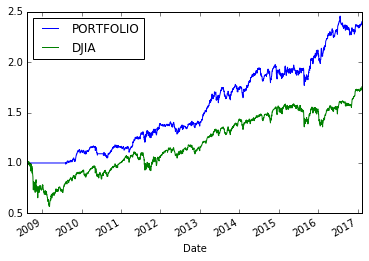

In [55]:
prices = data.get("PRICE").copy()
prices["CASH"] = 1.0
portfolio = agent.get_portfolio()
portfolio_weights = portfolio.get_portfolio_weights()
portfolio_returns = portfolio.calculate_portfolio_returns(prices)
cum_portfolio_returns = (portfolio_returns + 1).cumprod()

djia = pd.read_csv("{}/DJIA_PRICE.csv".format(path), index_col=0, parse_dates=True)\
        .ix[prices.index].fillna(method='ffill')
cum_djia_returns = (djia / djia.shift(1))[1:].cumprod()

cum_returns = pd.DataFrame(columns=["PORTFOLIO", "DJIA"], index=prices.index[1:])
cum_returns["PORTFOLIO"] = cum_portfolio_returns
cum_returns["DJIA"] = cum_djia_returns

cum_returns.plot()

In [38]:
weights = agent.get_portfolio().get_portfolio_weights().copy()

assets_held = weights.apply(lambda s: s.apply(lambda v: 1 if v > 0 else 0)).sum(axis=1)
print((assets_held / len(tickers)).mean())


0.458780487805


,DJIA
Date,
2017-02-10,20269.369141
2017-02-09,20172.400391
2017-02-08,20054.339844
2017-02-07,20090.289062
2017-02-06,20052.419922
2017-02-03,20071.460938
2017-02-02,19884.910156
2017-02-01,19890.939453
2017-01-31,19864.089844
